# Investigation on the use of radiomics for analysis of DAT SPECT imaging in Parkinson’s Disease

<a id="0"></a> <br>
 # Table of Contents  
1. [Import the necessary packages, libraries and methods](#1)     
2. [Load the Data](#2) 
3. [Train-Test Split](#3) 
4. [Feature Selection](#4)     
    4.1 [Correlation analysis between Radiomic features and target variable (Class -> PD/HC)](#5) <br>
    4.2 [FDR Correction](#6)<br>
    4.3 [LASSO](#7)<br>
    4.4 [Spearman Correlation between the features](#8)
5. [Classification](#9)   
    5.1 [SMOTE](#10)<br> 
    5.2 [SVM Classifier with Linear Kernel](#11)<br>
    5.3 [LDA Classifier](#12) <br>
    5.4 [Logistic Regression Classifier](#13)   <br> 
    5.5 [ROC Curve comparisons between the Classifiers](#14)

<a id="1"></a>
# 1. Import the necessary packages, libraries and methods

In [1]:
import pandas as pd
import numpy as np

#Feature Selection and Pre-processing Imports
from sklearn.preprocessing import StandardScaler

#Model Selection  and Classifier Imports
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV, LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC

#Metrics Imports
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, RocCurveDisplay
from sklearn.metrics import matthews_corrcoef, classification_report, roc_curve, auc, recall_score, f1_score, roc_auc_score

#Stats Imports
import scipy.stats as stats
from statsmodels.stats.multitest  import fdrcorrection as fdr
from scipy.stats import shapiro, spearmanr

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import pairplot as pplot

#Data Augmentation Library
from imblearn.over_sampling import SMOTE

<a id="2"></a>
# 2. Load the data

In [2]:
#Set the random seed 
np.random.seed(42)

#Import the radiomics and labels data
datapath = '../Data/Homework_Dataset.xlsx'

radiodf = pd.read_excel(datapath,sheet_name=0)
demodf = pd.read_excel(datapath,sheet_name=1)
X = radiodf.drop(columns = 'id_subject')
y = demodf['Group (1=PD, 0 = Controls)']



In [3]:
radiodf.head() #Check the first 5 radiomics samples

,id_subject,loc_peak_loc,loc_peak_glob,stat_mean,stat_var,stat_skew,stat_kurt,stat_median,stat_min,stat_p10,...,ngl_hdhge_d1_a0.0_3d_fbs_w0.0125,ngl_glnu_d1_a0.0_3d_fbs_w0.0125,ngl_glnu_norm_d1_a0.0_3d_fbs_w0.0125,ngl_dcnu_d1_a0.0_3d_fbs_w0.0125,ngl_dcnu_norm_d1_a0.0_3d_fbs_w0.0125,ngl_dc_perc_d1_a0.0_3d_fbs_w0.0125,ngl_gl_var_d1_a0.0_3d_fbs_w0.0125,ngl_dc_var_d1_a0.0_3d_fbs_w0.0125,ngl_dc_entr_d1_a0.0_3d_fbs_w0.0125,ngl_dc_energy_d1_a0.0_3d_fbs_w0.0125
0,ID_1,4.367148,4.378462,2.228290,0.667989,1.530631,1.511877,1.908921,1.500030,1.561387,...,14585.164244,30.287064,0.011005,1104.584302,0.401375,1,4274.447885,1.368704,8.429116,0.003936
1,ID_2,3.779030,3.803949,2.187555,0.384019,1.326379,1.168714,1.986067,1.500117,1.594954,...,11362.955467,20.953263,0.009239,1119.872134,0.493771,1,2456.642411,0.522943,8.141883,0.004538
2,ID_3,3.233660,3.233798,2.276786,0.359799,0.538311,-0.959822,2.123215,1.500243,1.591756,...,15962.161734,15.005285,0.007931,1018.762156,0.538458,1,2301.951850,0.413739,8.058827,0.004580
3,ID_4,5.084474,5.290133,2.677889,0.565180,1.113553,1.230447,2.510247,1.500425,1.856742,...,25117.256649,17.194819,0.005939,1527.539551,0.527648,1,3617.937748,0.446256,8.603763,0.003210
4,ID_5,4.535594,4.535594,2.165708,0.586335,1.631404,2.061551,1.837124,1.500109,1.555559,...,12542.362012,29.666667,0.012330,892.307564,0.370868,1,3753.531084,1.305924,8.368670,0.004104


In [4]:
demodf.head() #Check the first 5 demographic samples

,id_subject,"Group (1=PD, 0 = Controls)",Age,"Gender (M=0, F=1)",Education (Years),Height,Weight,BMI
0,ID_1,1,48,0,14,170.0,62.6,21.660900
1,ID_2,1,67,1,20,176.0,74.4,24.018595
2,ID_3,1,51,0,18,168.0,89.3,31.639739
3,ID_4,1,63,1,11,169.0,83.1,29.095620
4,ID_5,1,59,0,18,181.0,84.3,25.731815


<a id="3"></a> <br>
# 3. Train-Test Split

In [5]:
# Split the data into train and test sets such that the ratio of the classes in the train and test sets are the same

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)


for train_index, test_index in sss.split(X, y):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
trlabels, trfreqs = np.unique(y_train,return_counts=True)
tslabels, tsfreqs = np.unique(y_test,return_counts=True)

print('Train Labels:',trlabels,'-> Corresponding Frequencies',trfreqs)
print('Test Labels:',tslabels,'-> Corresponding Frequencies',tsfreqs)


Train Labels: [0 1] -> Corresponding Frequencies [14 23]
Test Labels: [0 1] -> Corresponding Frequencies [ 6 10]


<a id="4"></a>
# 4. Feature Selection

<a id="5"></a>
### 4.1 Correlation analysis between Radiomic features and target variable (Class -> PD/HC)

* Spearman Correlation

In [6]:
rho_spearman= []
pVal_spearman=[]
for column in X:
    rho, pVal =spearmanr(X_train[column],y_train)
    rho_spearman.append(rho)
    pVal_spearman.append(pVal)
    
# Create a dataframe with correlation between the features and the target variable
corr_df = pd.DataFrame({'Rho': rho_spearman, 'P_val': pVal_spearman})

# Print the dataframe
print('Spearman Correlation Results:')
print(corr_df)

Spearman Correlation Results:
          Rho         P_val
0   -0.636765  2.264781e-05
1   -0.641985  1.845345e-05
2   -0.715056  6.607158e-07
3   -0.694179  1.887778e-06
4    0.819444  5.589156e-10
..        ...           ...
172       NaN           NaN
173 -0.694179  1.887778e-06
174  0.840322  7.763300e-11
175 -0.694179  1.887778e-06
176  0.741153  1.551030e-07

[177 rows x 2 columns]


/Users/prateekgupta/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [7]:
# Delete the result with NAN as that particular feature just has a constant value throughout the dataset

corr_df=corr_df.T.drop(columns = 172)
corr_df=corr_df.T
corr_df

,Rho,P_val
0,-0.636765,2.264781e-05
1,-0.641985,1.845345e-05
2,-0.715056,6.607158e-07
3,-0.694179,1.887778e-06
4,0.819444,5.589156e-10
...,...,...
171,-0.840322,7.763300e-11
173,-0.694179,1.887778e-06
174,0.840322,7.763300e-11
175,-0.694179,1.887778e-06


<a id="6"></a>
### 4.2 FDR correction
* Correction for multiple comparisons

In [8]:
#fdr correction and add the results of testing the Null Hypothesis(H0) after the adjusted p-values keeping alpha=0.05
rejected, pVal_corrected =fdr(
    corr_df['P_val'], 
    alpha=0.05, 
    is_sorted=False
)
corr_df['H0_Rejected'] = rejected
corr_df['P_val_adjusted'] = pVal_corrected
corr_df

,Rho,P_val,H0_Rejected,P_val_adjusted
0,-0.636765,2.264781e-05,True,3.042759e-05
1,-0.641985,1.845345e-05,True,2.498313e-05
2,-0.715056,6.607158e-07,True,1.510208e-06
3,-0.694179,1.887778e-06,True,3.425247e-06
4,0.819444,5.589156e-10,True,4.098714e-09
...,...,...,...,...
171,-0.840322,7.763300e-11,True,8.539630e-10
173,-0.694179,1.887778e-06,True,3.425247e-06
174,0.840322,7.763300e-11,True,8.539630e-10
175,-0.694179,1.887778e-06,True,3.425247e-06


### Features after correlation analysis  

* Filter features where the adjusted p-value is significant
* Then retain only those features where the correlation coefficient `Rho > 0.6`

In [9]:
corr_df = corr_df[corr_df['H0_Rejected']==True]
spearman_reduced_features = corr_df[abs(corr_df['Rho'])>0.6].index
spearman_reduced_features

Int64Index([  0,   1,   2,   3,   4,   5,   6,   8,   9,  10,
            ...
            166, 167, 168, 169, 170, 171, 173, 174, 175, 176],
           dtype='int64', length=132)

<a id="7"></a>
### 4.3 LASSO
* Here we further pass the data with the reduced feature set to a LASSO Model (Logistic Regression with L1 penalty)


In [10]:
# Training set with the reduced features from the last step and standardizing the same

X_train_reduced = X_train.iloc[:,spearman_reduced_features]
scalar = StandardScaler().set_output(transform='pandas')
X_train_normalized = scalar.fit_transform(X_train_reduced)
X_test_normalized = scalar.transform(X_test.iloc[:,spearman_reduced_features])
X_train_normalized.shape

(37, 132)

In [11]:
# Create a Lasso model object
lasso = LogisticRegression(penalty='l1', solver='liblinear',C=10)  # Specify the regularization parameter C = 1/lambda

# Fit the Lasso model on the data
lasso.fit(X_train_normalized, y_train)

# Access the coefficients of the Lasso model
lasso_coef = lasso.coef_

selected_features = lasso.coef_[0] != 0

# Print the selected features

print('Features selected after LASSO:\n')

feature_names = X_train_normalized.columns
for feature in feature_names[selected_features]:
    print(feature)

Features selected after LASSO:

stat_skew
stat_qcod
ivh_v75
ivh_diff_v25_v75
ivh_diff_i25_i75
ih_skew_fbs_w0.0125
cm_inv_diff_d1_3d_avg_fbs_w0.0125
ngl_dcnu_d1_a0.0_3d_fbs_w0.0125
ngl_dcnu_norm_d1_a0.0_3d_fbs_w0.0125


<a id="8"></a>
### 4.4 Spearman correlation between features
* Then we do a pair-wise correlation analysis to select the least correlated features while also not reducing the number of features to say 1 or 2.

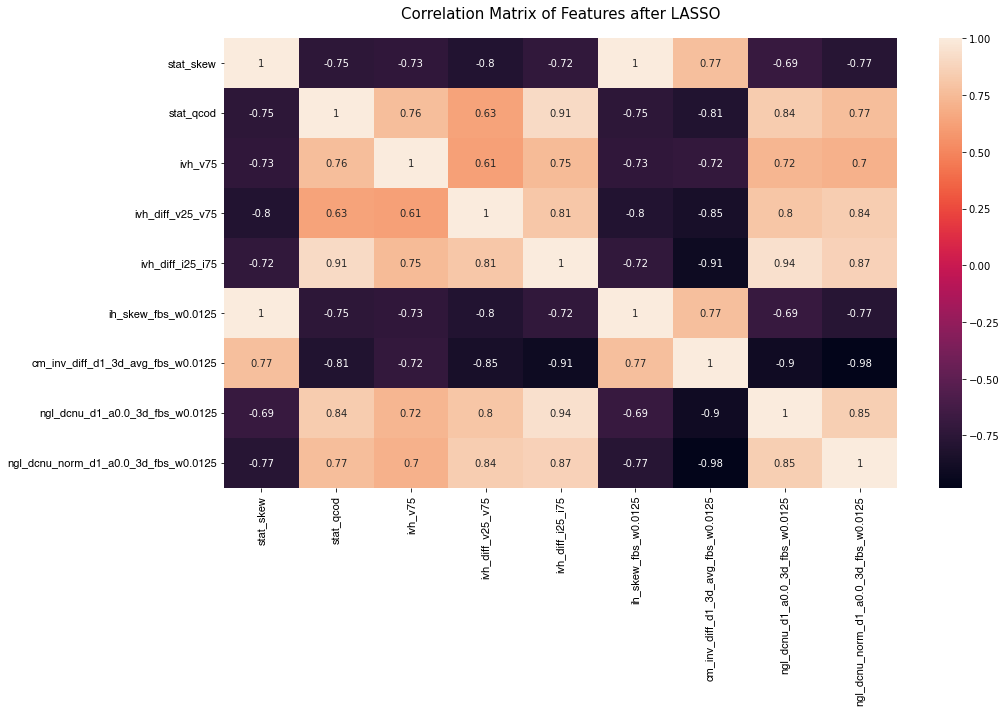

In [12]:
# Data with reduced features after LASSO
X_df = X_train_normalized[feature_names[selected_features]]
corr_matrix = X_df.corr(method = 'spearman')

rho,p = spearmanr(X_df)

# Plotting
fig, ax = plt.subplots(figsize=(15, 10)) # create the figure and the axes

# plt.subplots instead of plt.figure because it allows to get the axes directly
ax = sns.heatmap(rho, annot=True)
ax.set_title('Correlation Matrix of Features after LASSO', fontdict={'fontsize': 15}, pad=20)
ax.set_xticklabels(X_df.columns, rotation = 90, fontdict={'fontsize': 11, 'family': 'helvetica'})
ax.set_yticklabels(X_df.columns, rotation = 0, fontdict={'fontsize': 11, 'family': 'helvetica'})
fig.tight_layout()

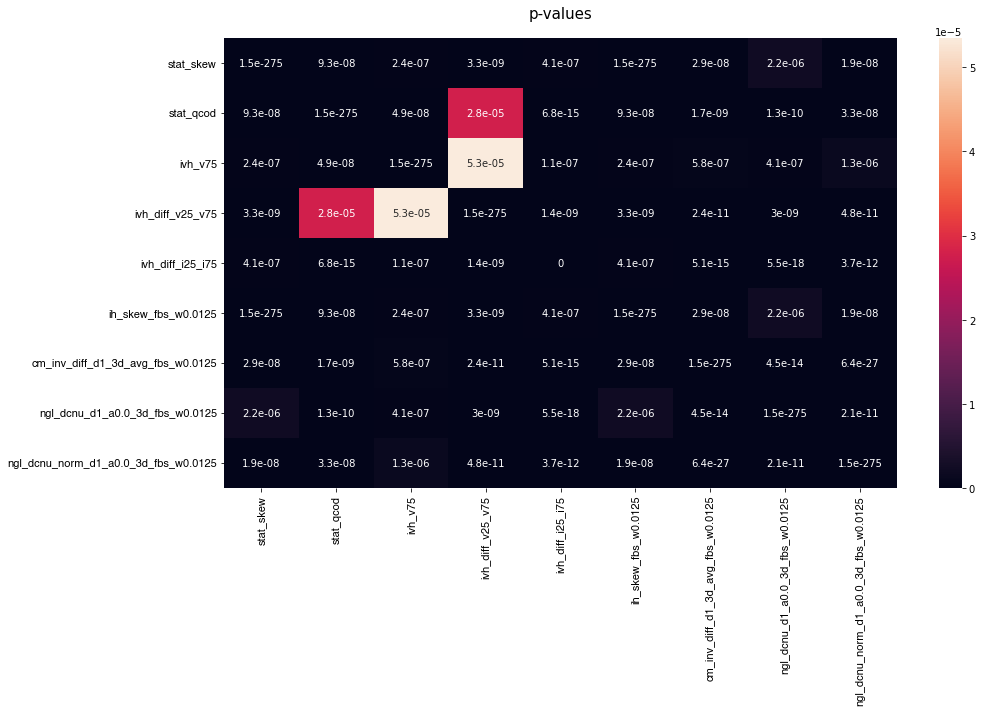

In [13]:
fig, ax = plt.subplots(figsize=(15, 10)) # create the figure and the axes

ax = sns.heatmap(p, annot=True)
ax.set_title('p-values', fontdict={'fontsize': 15}, pad=20)
ax.set_xticklabels(X_df.columns, rotation = 90, fontdict={'fontsize': 11, 'family': 'helvetica'})
ax.set_yticklabels(X_df.columns, rotation = 0, fontdict={'fontsize': 11, 'family': 'helvetica'})
fig.tight_layout()

In [14]:
# get upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.9)]
to_drop

['ivh_diff_i25_i75',
 'ih_skew_fbs_w0.0125',
 'cm_inv_diff_d1_3d_avg_fbs_w0.0125',
 'ngl_dcnu_d1_a0.0_3d_fbs_w0.0125',
 'ngl_dcnu_norm_d1_a0.0_3d_fbs_w0.0125']

In [15]:
# Final set of features
X_final = X_df.drop(columns=to_drop)
X_final.columns

Index(['stat_skew', 'stat_qcod', 'ivh_v75', 'ivh_diff_v25_v75'], dtype='object')

<a id="9"></a>
# 5. Classification 

* Balance the training set using SMOTE
* We use 3 Classifiers to see which one yields a better performance
* We employ SVM, LDA and Logistic Regression as our classifiers

In [16]:
# Train and Test set for classification with the final feature set

X_test_normlized = X_test_normalized[feature_names[selected_features]]
X_test_normlized = X_test_normlized.drop(columns=to_drop)
X_train_normalized = X_final

<a id="10"></a>
### 5.1 SMOTE

In [17]:
# Apply SMOTE oversampling to balance the training set

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_normalized, y_train)

# Create a dataframe for pair plot of the features in the training set

X_train_plot_df = X_train_resampled.copy()
X_train_plot_df['class'] = y_train_resampled
X_train_plot_df['class'] = X_train_plot_df['class'].replace(1,'PD').replace(0,'HC')
X_train_plot_df.head() #Top 5

,stat_skew,stat_qcod,ivh_v75,ivh_diff_v25_v75,class
0,1.070804,-0.445888,-0.765392,-1.038354,PD
1,0.254959,-0.674107,-0.444798,-0.496257,PD
2,0.269880,-0.560902,-0.902699,0.231280,PD
3,-0.928748,1.940112,0.821138,0.427013,HC
4,-1.075425,1.196326,0.711688,0.657512,HC


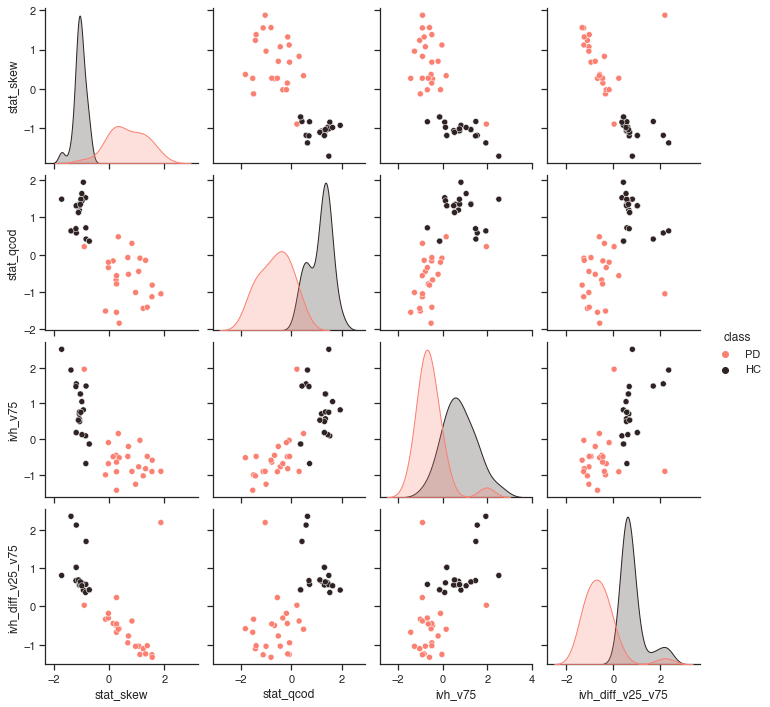

In [31]:
# Pair plot
sns.set_theme(font='helvetica', style='ticks')
pplot(X_train_plot_df,hue='class', palette = 'dark:salmon_r')

plt.savefig('pairplot')

<a id="11"></a>
### 5.2 SVM Classifier with Linear Kernel

In [19]:
# defining parameter range for Grid Search
param_grid = {
              'C': [0.001,0.01,0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'class_weight': ['balanced'],
              'kernel': ['linear']
             } 


clf = GridSearchCV(SVC(probability=True), param_grid, verbose = 1,cv=10, scoring='accuracy') # set verbose = 2 or 3 to see what GridSearchCV does
  
#fitting the model for grid search
clf = clf.fit(X_train_resampled, y_train_resampled)

# print best parameter after tuning
print('Best parameters: ',clf.best_params_)
print('Mean Accuracy of the cross-validation: ', clf.best_score_)

Fitting 10 folds for each of 35 candidates, totalling 350 fits
Best parameters:  {'C': 0.01, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'linear'}
Mean Accuracy of the cross-validation:  0.9800000000000001


In [20]:
# Results of the first 8 GridSearch CV runs 
pd.DataFrame(clf.cv_results_).iloc[:8,:]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_gamma,param_kernel,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004420,0.001492,0.002828,0.000698,0.001,balanced,1,linear,"{'C': 0.001, 'class_weight': 'balanced', 'gamm...",0.4,...,0.4,0.4,0.4,1.0,1.0,1.0,1.0,0.64,0.293939,31
1,0.003790,0.000587,0.002586,0.000614,0.001,balanced,0.1,linear,"{'C': 0.001, 'class_weight': 'balanced', 'gamm...",0.4,...,0.4,0.4,0.4,1.0,1.0,1.0,1.0,0.64,0.293939,31
2,0.003090,0.000362,0.002247,0.000555,0.001,balanced,0.01,linear,"{'C': 0.001, 'class_weight': 'balanced', 'gamm...",0.4,...,0.4,0.4,0.4,1.0,1.0,1.0,1.0,0.64,0.293939,31
3,0.005540,0.002305,0.003308,0.001585,0.001,balanced,0.001,linear,"{'C': 0.001, 'class_weight': 'balanced', 'gamm...",0.4,...,0.4,0.4,0.4,1.0,1.0,1.0,1.0,0.64,0.293939,31
4,0.006876,0.001392,0.004993,0.000977,0.001,balanced,0.0001,linear,"{'C': 0.001, 'class_weight': 'balanced', 'gamm...",0.4,...,0.4,0.4,0.4,1.0,1.0,1.0,1.0,0.64,0.293939,31
5,0.006206,0.001452,0.004665,0.001456,0.01,balanced,1,linear,"{'C': 0.01, 'class_weight': 'balanced', 'gamma...",1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.98,0.060000,1
6,0.006734,0.001639,0.005893,0.002522,0.01,balanced,0.1,linear,"{'C': 0.01, 'class_weight': 'balanced', 'gamma...",1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.98,0.060000,1
7,0.006847,0.001749,0.004729,0.002058,0.01,balanced,0.01,linear,"{'C': 0.01, 'class_weight': 'balanced', 'gamma...",1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.98,0.060000,1


In [21]:
# Prediction on the Test set and the corresponding classification report

y_svc = clf.predict(X_test_normlized)
print('\nClassification Report:\n')
print(classification_report(y_test, y_svc)) # 0 -> HC, 1 -> PD


Classification Report:

              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.90      0.95        10

    accuracy                           0.94        16
   macro avg       0.93      0.95      0.94        16
weighted avg       0.95      0.94      0.94        16



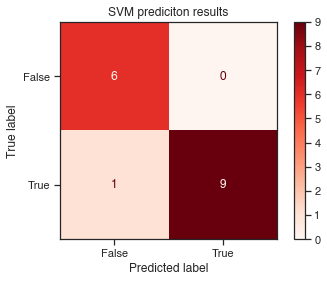

Model ROC-AUC: 0.95
Accuracy score for test set: 0.9375
Matthew Correlation Coeff: 0.8783100656536799


In [22]:
#Confusion Matrix of the predictions

cm = metrics.confusion_matrix(y_test,y_svc)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = [False, True],
   
)
cm_display = cm_display.plot(cmap=plt.cm.Reds,values_format='g')
plt.grid(False)
plt.title('SVM prediciton results')
plt.show()


print ('Model ROC-AUC:',roc_auc_score(y_test,y_svc))
print('Accuracy score for test set:',accuracy_score(y_test,y_svc))
print('Matthew Correlation Coeff:',matthews_corrcoef(y_test, y_svc))

<a id="12"></a>
### 5.3 LDA Classifier 

In [23]:
lda_clf = LinearDiscriminantAnalysis()
parameters = {
    'solver': [ 'lsqr'],
    'n_components':[1],
    'store_covariance': [True, False],
    'tol': [0.1,1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}
clf = GridSearchCV(lda_clf, parameters, cv=10, n_jobs=-1, scoring='accuracy') #njobs = -1 for using all processors
clf.fit(X_train_resampled, y_train_resampled)


GridSearchCV(cv=10, estimator=LinearDiscriminantAnalysis(), n_jobs=-1,
             param_grid={'n_components': [1], 'solver': ['lsqr'],
                         'store_covariance': [True, False],
                         'tol': [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07,
                                 1e-08, 1e-09, 1e-10, 1e-11, 1e-12, 1e-13,
                                 1e-14, 1e-15]},
             scoring='accuracy')

In [24]:
# print best parameter after tuning
print('Best parameters:',clf.best_params_)
print('Mean Accuracy of the cross-validation:', clf.best_score_)

Best parameters: {'n_components': 1, 'solver': 'lsqr', 'store_covariance': True, 'tol': 0.1}
Mean Accuracy of the cross-validation: 0.9800000000000001


In [25]:
# Prediction on the Test set and the corresponding classification report

y_lda = clf.predict(X_test_normlized)
print(classification_report(y_test, y_lda))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        10

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



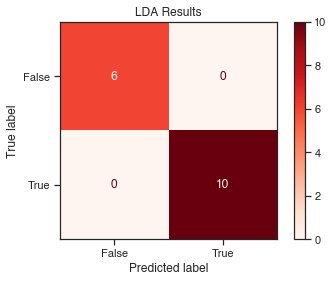

Model ROC-AUC:  1.0
Accuracy  score Test:  1.0
Matthew Correlation Coeff 1.0


In [26]:
#Confusion Matrix of the predictions

cm = metrics.confusion_matrix(y_test,y_lda)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = [False, True],
    
)
cm_display = cm_display.plot(cmap=plt.cm.Reds,values_format='g')
plt.grid(False)
plt.title('LDA Results')
plt.show()

#printing Roc_auc score
print ('Model ROC-AUC: ',roc_auc_score(y_test,y_lda))
print('Accuracy  score Test: ',accuracy_score(y_test,y_lda))
print('Matthew Correlation Coeff',matthews_corrcoef(y_test, y_lda))

<a id="13"></a>
### 5.4 Logistic Regression Classifier

In [27]:
# instantiate the model
logreg = LogisticRegressionCV(solver='liblinear', cv=10, scoring='accuracy') #In Built cross validation
logreg.fit(X_train_resampled,y_train_resampled)

print('Mean Accuracy of the cross-validation:', logreg.score(X_train_resampled,y_train_resampled))

Mean Accuracy of the cross-validation: 0.9782608695652174


In [28]:
y_log = logreg.predict(X_test_normlized)
print(classification_report(y_test, y_log))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.90      0.95        10

    accuracy                           0.94        16
   macro avg       0.93      0.95      0.94        16
weighted avg       0.95      0.94      0.94        16



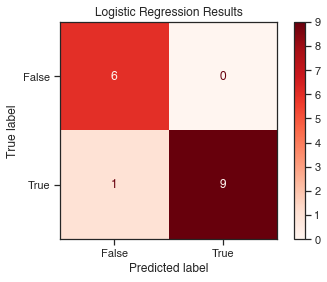

Model ROC-AUC:  0.95
Accuracy  score Test:  0.9375
Matthew Correlation Coeff 0.8783100656536799


In [29]:
cm = metrics.confusion_matrix(y_test,y_log)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = [False, True],
   
)
cm_display = cm_display.plot(cmap=plt.cm.Reds,values_format='g')
plt.grid(False)
plt.title('Logistic Regression Results')
plt.show()

#printing Roc_auc score
print ('Model ROC-AUC: ',roc_auc_score(y_test,y_log))
print('Accuracy  score Test: ',accuracy_score(y_test,y_log))
print('Matthew Correlation Coeff',matthews_corrcoef(y_test, y_log))

<a id="14"></a>
### 5.5 ROC Curve comparisons for the three classifiers

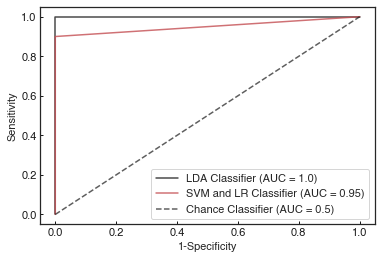

In [30]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test,y_lda, ax = ax, color = 'k', alpha= 0.8)
RocCurveDisplay.from_predictions(y_test,y_svc, ax = ax, color = 'r', alpha= 0.8) #same for LR as well

ax.plot([0,1], [0,1], 'k', linestyle="--", alpha = 0.7)
ax.set_xlabel('1-Specificity', fontdict={'size':11, 'family': 'helvetica'})
ax.set_ylabel('Sensitivity', fontdict={'size':11, 'family':'helvetica'})
ax.tick_params(direction='in',length=3, width=1, colors='k')
ax.grid(False)
ax.legend(['LDA Classifier (AUC = 1.0)','SVM and LR Classifier (AUC = 0.95)','Chance Classifier (AUC = 0.5)'], loc='lower right')

plt.savefig('ROC curve')
plt.show()